In [1]:
# store -r # comment out to load all the variables

### Load the needed modules

In [2]:
import pandas as pd
import numpy as np
import warnings

# To filter out all warnings (not recommended)
warnings.filterwarnings("ignore")

# Machine Learning Tasks
from sklearn.metrics import roc_curve, auc, make_scorer, confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
import time

# Confidence Interval
import scipy.stats
from scipy import stats

# Explainable AI
import shap

# Diet-Met Correlation and Heatmaps
import pingouin as pg
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import matplotlib as mpl
import seaborn as sns

### Read in the data

In [20]:
file_path = ["../R Processed Data/BB_imp_sc_trans_filt_label.csv", 
             "../R Processed Data/HMP_imp_sc_trans_filt_label.csv"]

file_name = ["UK Biobank (plasma)",
             "HMP2 IBDMDB (feces)"]

X_list = []
y_list = []
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []


for dataset_id in range(len(file_path)):
    X = pd.read_csv(file_path[dataset_id], index_col=0).sort_index()
    y = X['Label']
    y = y.replace({'IBD': 1, 'nonIBD': 0})
    X = X.drop('Label', axis=1)
    
    ### TRAIN TEST SPLIT ###
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, stratify = y, random_state=42)
    
    ### TRAIN TEST SPLIT ###
    #X_train, X_test, y_train, y_test = train_test_split(
    #    X_train, y_train, test_size=0.2, shuffle=True, stratify = y_train, random_state=42)
    
    X_list.append(X)
    y_list.append(y)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)

## Machine Learning: RF-based Classification

UK Biobank (plasma)

Repitition 1 Best Grid Model took 11.83 mins (710.08 secs)
RandomForestClassifier(max_depth=5, max_features=None, max_samples=0.5,
                       n_estimators=1000, random_state=42)
Actual trained number of trees: 1000
Best Grid Model score: 0.6416765371778974
Optimal Number of Trees based on validation set: 309
Validation AUC Score: 0.6757149177036424

Repitition 2 Best Grid Model took 10.11 mins (606.73 secs)
RandomForestClassifier(max_depth=10, max_features=0.5, max_samples=0.5,
                       n_estimators=1000, random_state=42)
Actual trained number of trees: 1000
Best Grid Model score: 0.6585962608157505
Optimal Number of Trees based on validation set: 472
Validation AUC Score: 0.6329668733049205

Repitition 3 Best Grid Model took 10.40 mins (624.20 secs)
RandomForestClassifier(max_depth=20, max_features=0.5, max_samples=0.5,
                       n_estimators=1000, random_state=42)
Actual trained number of trees: 1000
Best Grid Model score: 0

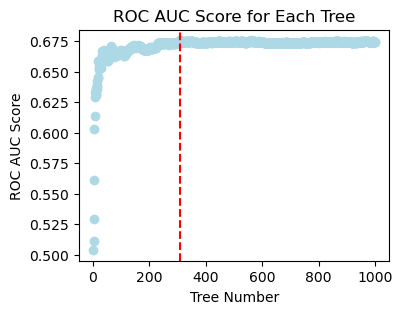

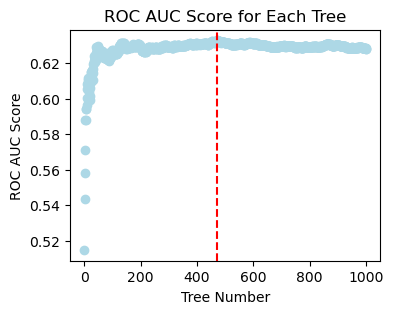

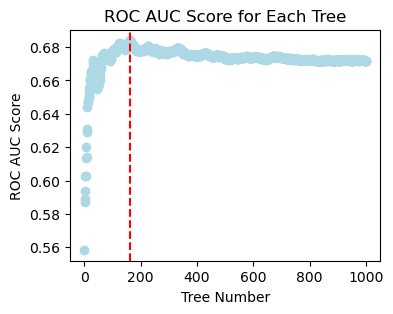

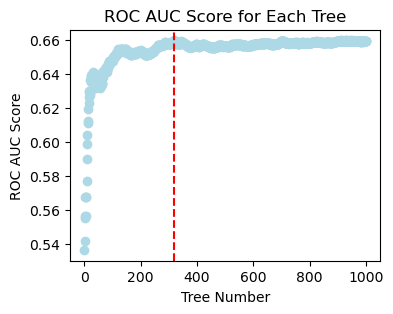

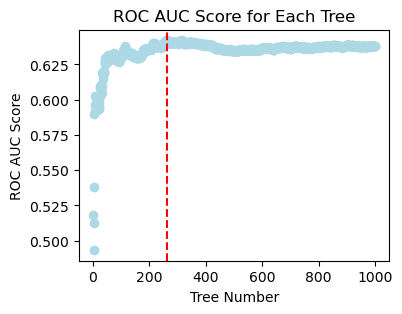

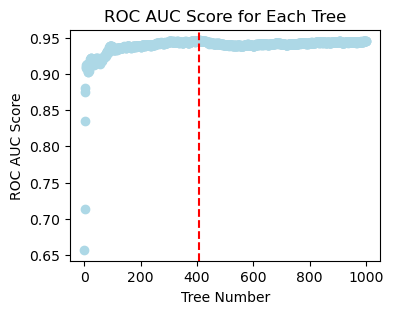

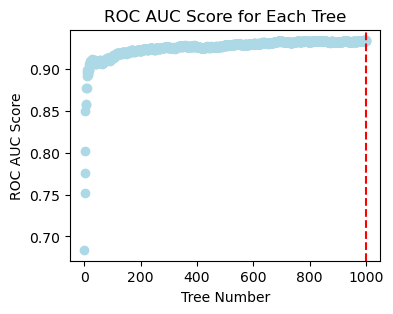

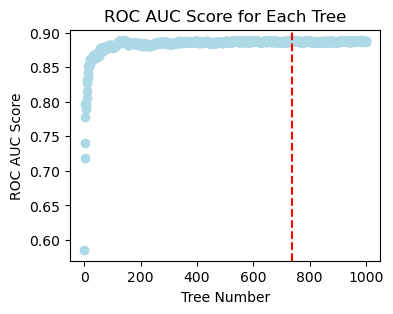

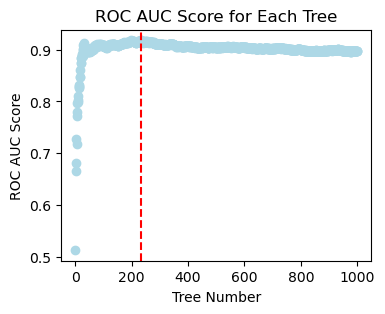

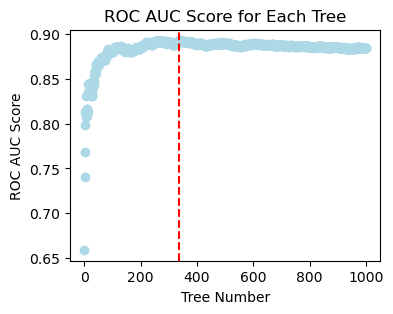

In [21]:
TOTAL_TREES = 1000
FOLDS = 5
REPEATS = 5 # for repeating through each combination of test-train split 
# for testing how each 1000 tree model performs repeatedly (REPEATS times) for each 5 skf

base_model = RandomForestClassifier(n_estimators=TOTAL_TREES, random_state=42)
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
classifier_list = []
fpr = []
tpr = []
auc_score = []
y_pred_prob_list = []

for dataset_id in range(len(file_path)):  # iterate over all datasets
    print(file_name[dataset_id])
    print()
    
    scorer = make_scorer(roc_auc_score, needs_threshold=True)
    
    # Set up param_grid based on dataset_id
    if dataset_id == 0:
        criterion_values = ['gini']
    elif dataset_id == 1:
        criterion_values = ['entropy']
    
    param_grid = {
        'max_samples': [0.5, 0.8], 
        'max_features': ['sqrt', 0.3, 0.5, None],
        'max_depth': [5, 10, 20, 30], 
        'criterion': criterion_values
    }
    
    # to store the best grid models
    best_grid_model_repeat = []
    
    # the five train-validation subsets (REPEATS)
    for repeat in range(REPEATS):
        train_indices, test_indices = train_test_split(X_train_list[dataset_id].index, 
                                                       shuffle = True, test_size = 0.3, 
                                                       random_state=repeat)
        X_train = X_train_list[dataset_id].loc[train_indices]
        y_train = y_train_list[dataset_id].loc[train_indices]
        X_valid = X_train_list[dataset_id].loc[test_indices]
        y_valid = y_train_list[dataset_id].loc[test_indices]

        # perform hyperparamter tuning (while timing the process)
        time_start = time.time()

        grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, 
                                   scoring=make_scorer(roc_auc_score, needs_threshold=True), 
                                   cv=skf, n_jobs=-1)
        grid_search.fit(X_train.values, y_train)
        
        time_grid = time.time() - time_start
        
        best_grid_model = grid_search.best_estimator_
        
        # Lists to store ROC AUC scores and estimator counts
        score_rocauc = []
        max_rocauc = 0
        tree_counts = []
        
        # Loop through each estimator in the ensemble
        for count, estimator in enumerate(best_grid_model.estimators_):
            proba = estimator.predict_proba(X_valid.values)[:, 1]

            # Accumulate the probabilities for the ROC curve
            if count == 0:
                y_valid_pred_prob = proba
            else:
                y_valid_pred_prob += proba

            fpr_n, tpr_n, _ = roc_curve(y_valid, y_valid_pred_prob / float(count + 1.0))

            # Calculate ROC AUC for this estimator
            roc_auc = auc(fpr_n, tpr_n)

            # Store ROC AUC and estimator count for this estimator
            score_rocauc.append(roc_auc)
            tree_counts.append(count + 1)

            # Update the overall best ROC AUC and estimator count if needed
            if roc_auc > max_rocauc:
                max_rocauc = roc_auc
                best_tree_num = count + 1

        print(f"Repitition {repeat + 1} Best Grid Model took {time_grid/60:.2f} mins ({time_grid:.2f} secs)")
        print(best_grid_model)
        print(f"Actual trained number of trees: {len(best_grid_model.estimators_)}")
        print(f"Best Grid Model score: {grid_search.best_score_}")
        print(f"Optimal Number of Trees based on validation set: {best_tree_num}")
        print(f"Validation AUC Score: {max_rocauc}\n")
        
        # Plot AUC scores for each tree
        plt.figure(figsize=(4, 3))
        plt.scatter(tree_counts, score_rocauc, color='lightblue')
        plt.xlabel('Tree Number')
        plt.ylabel('ROC AUC Score')
        plt.title('ROC AUC Score for Each Tree')

        # Draw a vertical line at the best_tree_num
        plt.axvline(x=best_tree_num, color='red', linestyle='--', label=f'Best Tree: {best_tree_num} ({np.max(score_rocauc):.4f})')
        
        # Store the results for this repeat
        best_grid_model_repeat.append([max_rocauc, best_grid_model, best_tree_num])
        best_grid_model_repeat.sort(key=lambda x: x[0], reverse=True)
    
    # Find the sublist with the maximum max_rocauc
    best_repeat_model = best_grid_model_repeat[0][1]
    params = best_repeat_model.get_params()
    params['n_estimators'] = best_grid_model_repeat[0][2]
    best_repeat_model = RandomForestClassifier(**params)
    classifier_list.append(best_repeat_model.fit(X_train_list[dataset_id].values, y_train_list[dataset_id]))
    
    # predict and evaluate model performance (AUC)
    y_pred_prob_list.append(classifier_list[dataset_id].predict_proba(X_test_list[dataset_id].values)[:, 1])
    
    fpr_num, tpr_num, _ = roc_curve(y_test_list[dataset_id], y_pred_prob_list[dataset_id])
    auc_score_num = auc(fpr_num, tpr_num)
    fpr.append(fpr_num)
    tpr.append(tpr_num)
    auc_score.append(auc_score_num)
    
    # Calculate other performance metrics
    true_labels = y_test_list[dataset_id].values
    predicted_labels = classifier_list[dataset_id].predict(X_test_list[dataset_id].values)
    confusion = confusion_matrix(true_labels, predicted_labels)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    specificity = TN / (TN + FP)
    recall = recall_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    
    print("FINAL OPTIMIZED MODEL\n:", classifier_list[dataset_id])
    print("AUC: ", auc_score_num)
    print("Specificity:", specificity)
    print("Sensitivity (Recall):", recall)
    print("Precision:", precision)
    print("F1 Score:", f1)
    print("Balanced Accuracy:", balanced_accuracy)
    print("="*60)
    print()

#### Calculate Confidence Intervals

In [5]:
# this code chunk was copied and pasted. It is used to calculate the confidence intervals for the AUC-ROC score

"""
Created on Tue Nov  6 10:06:52 2018

@author: yandexdataschool

Original Code found in:
https://github.com/yandexdataschool/roc_comparison

updated: Raul Sanchez-Vazquez
"""

import numpy as np
import scipy.stats
from scipy import stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def compute_midrank_weight(x, sample_weight):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    cumulative_weight = np.cumsum(sample_weight[J])
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = cumulative_weight[i:j].mean()
        i = j
    T2 = np.empty(N, dtype=np.float)
    T2[J] = T
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count, sample_weight):
    if sample_weight is None:
        return fastDeLong_no_weights(predictions_sorted_transposed, label_1_count)
    else:
        return fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight)


def fastDeLong_weights(predictions_sorted_transposed, label_1_count, sample_weight):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank_weight(positive_examples[r, :], sample_weight[:m])
        ty[r, :] = compute_midrank_weight(negative_examples[r, :], sample_weight[m:])
        tz[r, :] = compute_midrank_weight(predictions_sorted_transposed[r, :], sample_weight)
    total_positive_weights = sample_weight[:m].sum()
    total_negative_weights = sample_weight[m:].sum()
    pair_weights = np.dot(sample_weight[:m, np.newaxis], sample_weight[np.newaxis, m:])
    total_pair_weights = pair_weights.sum()
    aucs = (sample_weight[:m]*(tz[:, :m] - tx)).sum(axis=1) / total_pair_weights
    v01 = (tz[:, :m] - tx[:, :]) / total_negative_weights
    v10 = 1. - (tz[:, m:] - ty[:, :]) / total_positive_weights
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def fastDeLong_no_weights(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Oerating
              Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth, sample_weight):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    if sample_weight is None:
        ordered_sample_weight = None
    else:
        ordered_sample_weight = sample_weight[order]

    return order, label_1_count, ordered_sample_weight


def delong_roc_variance(ground_truth, predictions, sample_weight=None):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count, ordered_sample_weight = compute_ground_truth_statistics(
        ground_truth, sample_weight)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count, ordered_sample_weight)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

In [6]:
for dataset_id in range(len(file_path)):  # iterate over all datasets
    print(file_name[dataset_id])
    alpha = .95
    y_pred = y_pred_prob_list[dataset_id]
    y_true = y_test_list[dataset_id]

    auc, auc_cov = delong_roc_variance(
        y_true,
        y_pred)

    auc_std = np.sqrt(auc_cov)
    lower_upper_q = np.abs(np.array([0, 1]) - (1 - alpha) / 2)

    ci = stats.norm.ppf(
        lower_upper_q,
        loc=auc,
        scale=auc_std)

    ci[ci > 1] = 1

    print('AUC:', auc)
    print('AUC COV:', auc_cov)
    print(f"{alpha*100}% AUC CI: {ci}")
    print("="*30)
    print()

UK Biobank (plasma)
AUC: 0.6486961990888692
AUC COV: 0.0007119051189464392
95.0% AUC CI: [0.59640132 0.70099108]

HMP2 IBDMDB (feces)
AUC: 0.9336143308746048
AUC COV: 0.0008172635088494608
95.0% AUC CI: [0.87758323 0.98964543]



#### Plot the AUC-ROC Curves

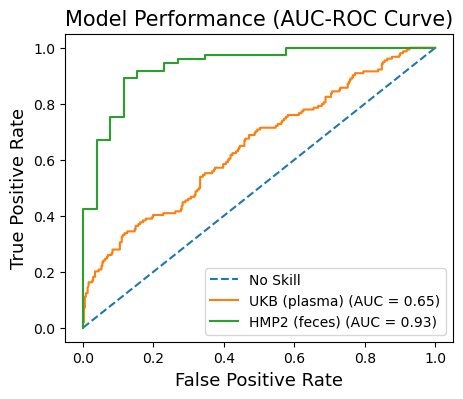

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

file_name = ["UKB (plasma)",
             "HMP2 (feces)"]

# generate for No SKill
ns_probs = [0 for _ in range(len(y_test_list[0]))]
ns_auc = roc_auc_score(y_test_list[0], ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test_list[0], ns_probs)

plt.figure(figsize=(5, 4))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
for i in range(len(file_path)):
    plt.plot(fpr[i], tpr[i], label='{} (AUC = {:.2f})'.format(file_name[i], auc_score[i]))
plt.xlabel('False Positive Rate', size=13)
plt.ylabel('True Positive Rate', size=13)
plt.title('Model Performance (AUC-ROC Curve)', size=15)
plt.legend()
plt.savefig('ML and XAI/AUC-ROC Curve.png')
plt.show()

------------
## Explainable AI: SHAP

In [8]:
# Explaining predictions
explainer = [i for i in range(len(file_path))]
shap_values = [i for i in range(len(file_path))]
shap_values_df = [i for i in range(len(file_path))]

# Calculate SHAP values
for i in range(len(file_path)):
    explainer[i] = shap.Explainer(classifier_list[i])
    shap_values[i] = explainer[i].shap_values(X_test_list[i])
    shap_values_df[i] = pd.DataFrame(shap_values[i][1], columns=X_list[i].columns, index=X_test_list[i].index)

In [23]:
# Finding the top features

selected_features_list = []

for i in range(len(file_path)):
    # Calculate the mean of absolute values for each column
    abs_mean_values = np.abs(shap_values_df[i]).mean()

    # Initialize variables
    total_contribution = 0
    selected_features = []
    bottom_features = []

    # Sort the features by absolute mean values in descending order
    sorted_features = abs_mean_values.sort_values(ascending=False)

    # selecting the top 20 features
    selected_features = sorted_features[:20].index.values
    total_contribution = sorted_features[:20].values.sum()
    
    # Calculate the top-bottom ratio
    count = len(selected_features)
    bottom_features = abs_mean_values.nsmallest(count).index.tolist()
    bottom_features_contribution =  abs_mean_values[bottom_features].sum() / abs_mean_values.sum()
    top_features_contribution = total_contribution / abs_mean_values.sum()
    tb_ratio = top_features_contribution / bottom_features_contribution

    # Print the selected features, their cumulative contribution, and odds ratio
    print("Selected Features:", selected_features)
    print("Number of Features:", len(selected_features))
    print("% of Total Features:", count/len(abs_mean_values)*100)
    print("Cumulative Contribution of Top Features:", top_features_contribution)
    print("Cumulative Contribution of Bottom Features:", bottom_features_contribution)
    print("Ratio of Top to Bottom Features:", tb_ratio)
    print()
    
    selected_features_list.append(selected_features)

Selected Features: ['GlycA' 'S-LDL-FC' 'Albumin' 'Unsaturation' 'Glycine' 'Valine'
 'XL-HDL-FC' 'Leucine' 'Glucose' 'Creatinine' 'Omega-3' 'Histidine'
 'Acetate' 'Acetone' 'Phosphatidylc' 'Alanine' 'Sphingomyelins' 'LA'
 'S-HDL-CE' 'Glutamine']
Number of Features: 20
% of Total Features: 54.054054054054056
Cumulative Contribution of Top Features: 0.7703451225669586
Cumulative Contribution of Bottom Features: 0.2861541647576866
Ratio of Top to Bottom Features: 2.6920632911957845

Selected Features: ['NUA' 'C16:0 SM' 'Urobilin' 'C18:1 LPC-P' 'NMPC' 'Taurine' 'Pyridoxine'
 'N-AcPut' 'C36:2 PC' '1-MNA' '7-MeG' 'Hydroxycotinine' 'C18:0 LPE-A'
 'C18:2 Carnitine' 'Acetaminophen' 'C16:1 LPC-P' 'C16:0 LPE'
 'Trigonelline' 'Cotinine' 'N-MePro']
Number of Features: 20
% of Total Features: 12.422360248447205
Cumulative Contribution of Top Features: 0.6386467377808683
Cumulative Contribution of Bottom Features: 0.015628862774822287
Ratio of Top to Bottom Features: 40.86328909418237



#### Generating the Summary Plots

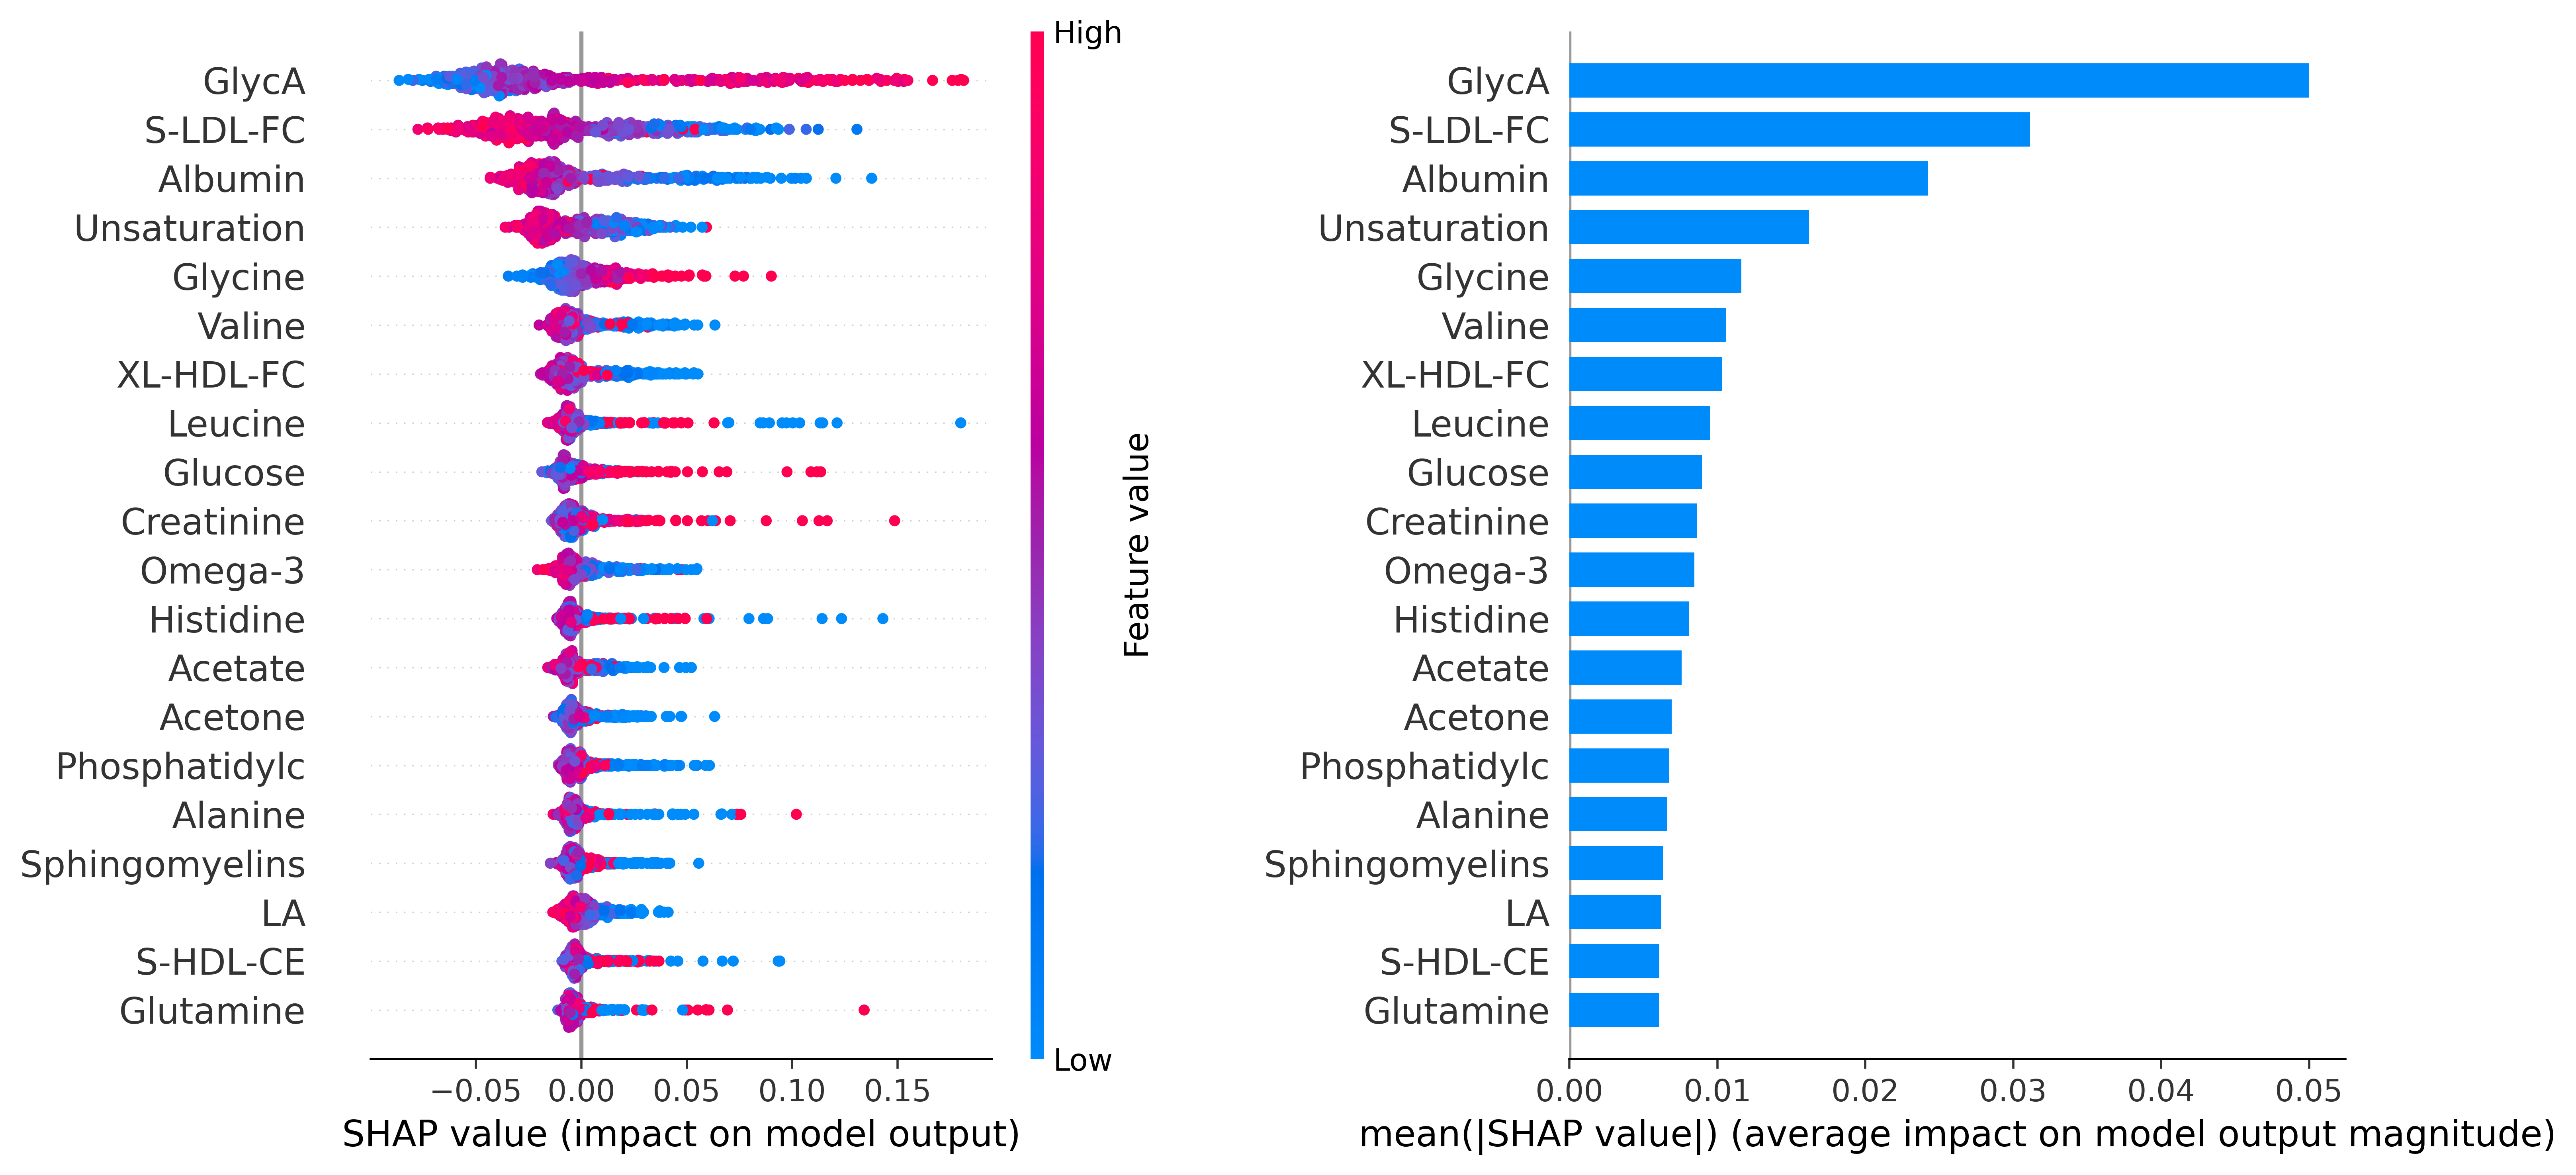

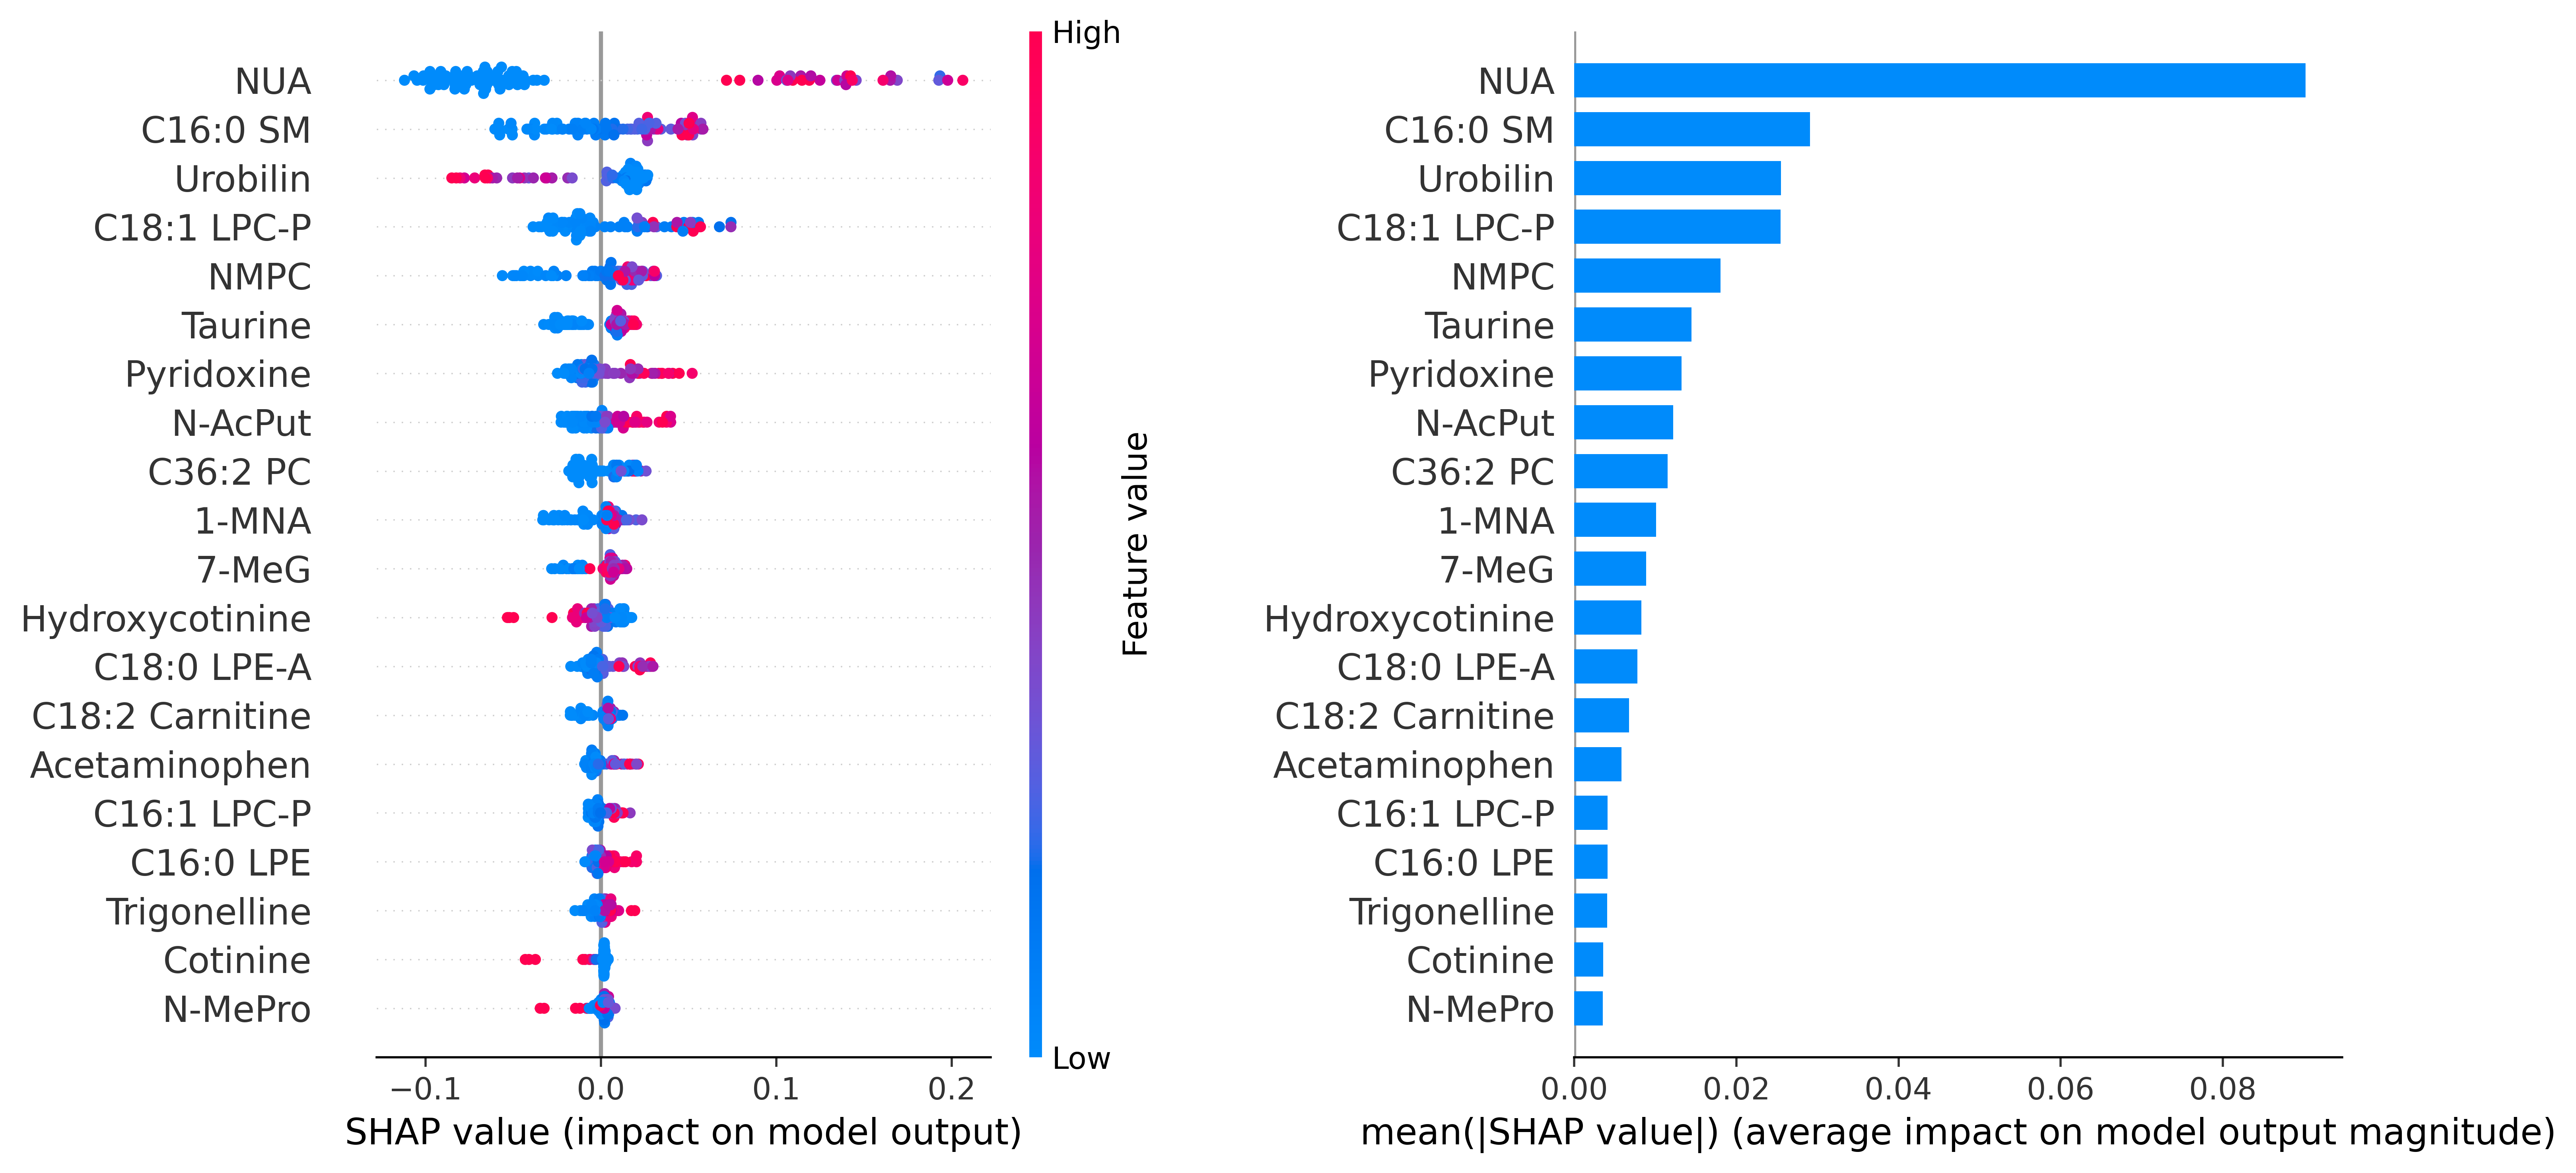

In [10]:
for i in range(len(shap_values_df)):
    fig = plt.figure(dpi=500)
    ax0 = fig.add_subplot(131)
    shap.summary_plot(shap_values[i][1], X_test_list[i], show=False, max_display=len(selected_features_list[i]), plot_type='dot')
    ax1 = fig.add_subplot(132)
    shap.summary_plot(shap_values[i][1],  X_test_list[i], show=False, max_display=len(selected_features_list[i]), plot_type='bar')
    plt.gcf().set_size_inches(18,6)
    plt.tight_layout() 
    # export the figures
    plt.savefig('ML and XAI/{}_summary_mean.png'.format(file_name[i]), bbox_inches='tight')
    plt.show()
    # Export the ranked metabolites:
    import numpy as np
    vals= np.abs(shap_values[i]).mean(0)
    feature_importance = pd.DataFrame(list(zip(X_test_list[i].columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    ranked_features = feature_importance['col_name'].values
    # export the original dataframe with the values but shap ranked
    pd.concat([y_list[i], X_list[i][ranked_features]], axis = 1).to_csv(f"ML and XAI/X values Shap-Ranked for {file_name[i]}.csv", index = True)
    # export the shap values dataframe in the shap-ranked order
    pd.concat([y_test_list[i], shap_values_df[i][ranked_features]], axis = 1).to_csv(f"ML and XAI/SHAP values Shap-Ranked for {file_name[i]}.csv", index = True)

##### Store the variables

In [11]:
# %store classifier_list
# %store fpr 
# %store tpr
# %store auc_score
# %store X_test
# %store y_test
# %store explainer
# %store shap_values
# %store shap_values_df
# %store selected_features_list
# %store file_path

Stored 'classifier_list' (list)
Stored 'fpr' (list)
Stored 'tpr' (list)
Stored 'auc_score' (list)
Stored 'X_test' (DataFrame)
Stored 'y_test' (Series)
Stored 'explainer' (list)
Stored 'shap_values' (list)
Stored 'shap_values_df' (list)
Stored 'selected_features_list' (list)
Stored 'file_path' (list)


# Diet - Metabolite Interactions

UKBB (plasma) IBD:
Total Correlations (|r| >= 0.1): 48
Total Significant Correlations: 48
lp: -0.116, up: 0.11505000000000001
Total Extreme Correlations (lp > r > up): 35
Total Significant Extreme Correlations: 35

HMP2 (feces) IBD:
Total Correlations (|r| >= 0.1): 106
Total Significant Correlations: 62
lp: -0.13905, up: 0.144
Total Extreme Correlations (lp > r > up): 40
Total Significant Extreme Correlations: 40



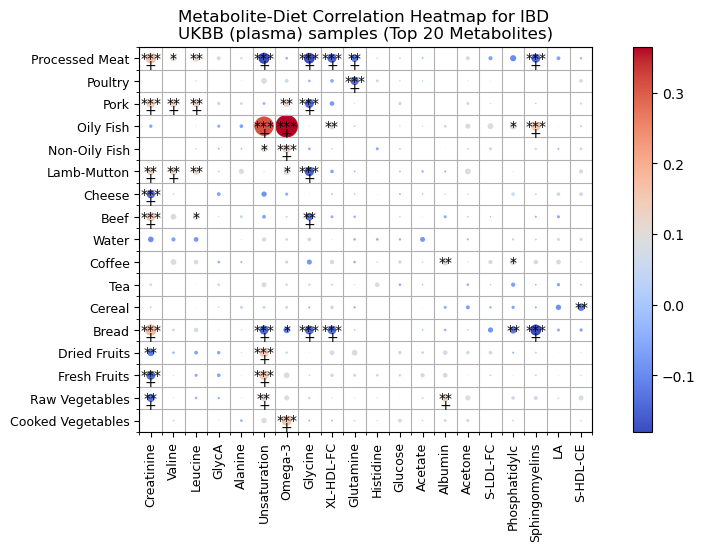

<Figure size 1000x1000 with 0 Axes>

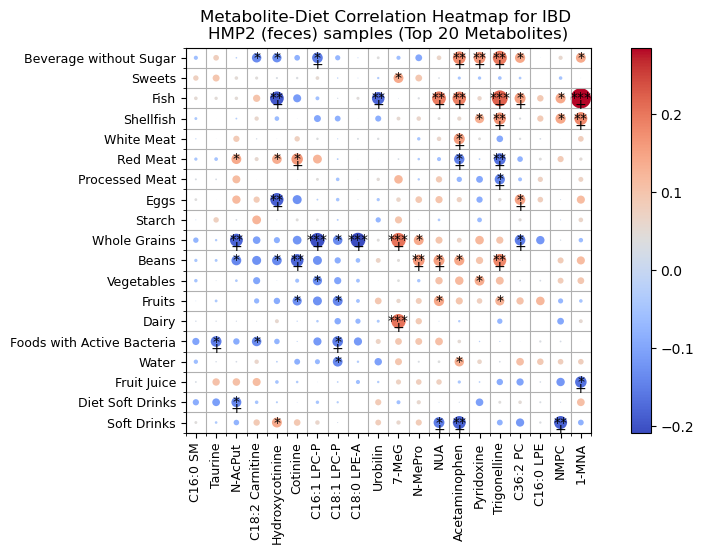

<Figure size 1000x1000 with 0 Axes>

In [24]:
diet_file_path = [
    "../R Processed Data/BBdiet.csv",
    "../R Processed Data/HMPdiet.csv"
]

SHAPmetabolite_file_path = [
    "ML and XAI/X values Shap-Ranked for UKB (plasma).csv",
    "ML and XAI/X values Shap-Ranked for HMP2 (feces).csv"
]

file_names = ["UKBB (plasma)",
         "HMP2 (feces)"]
    
for i in range(len(file_names)):

    x = pd.read_csv(diet_file_path[i], index_col=0)
    y = pd.read_csv(SHAPmetabolite_file_path[i], index_col=0)
    
    ibd = 1 ## <- EDIT THIS TO GENERATE FIGURES FOR ONLY IBD (1), ONLY NON-IBD (0), OR BOTH (any other number)
    
    if ibd == 0:
        class_id = "Non-IBD"
        y = y[y['Label'] == ibd]
    elif ibd == 1:
        class_id = "IBD"
        y = y[y['Label'] == ibd]
    else:
        class_id = "All"
        
    y = y.loc[:, y.columns != 'Label']
    x = x[x.index.isin(y.index)]
    
    # only display the diet-metabolite heatmap for the top features
    y = y.iloc[:, :len(selected_features_list[i])]

    df = pd.concat([x, y], axis=1)
    
    # calculate correlation
    r = df.rcorr(method='spearman', padjust='fdr_bh').iloc[x.shape[1]:, :-y.shape[1]]
    r.T.to_csv(f"Diet-Metabolite/Correlation Table for {file_names[i]} {class_id}.csv", index=True)
    # calculate significant stars
    stars = df.rcorr(method='spearman', padjust='fdr_bh').iloc[:x.shape[1], x.shape[1]:].T
    # calculate significance
    p = df.rcorr(method='spearman', padjust='fdr_bh', stars=True, decimals = 150).iloc[:x.shape[1], x.shape[1]:].T
    p.T.to_csv(f"Diet-Metabolite/P-value Correlation Table for {file_names[i]} {class_id}.csv", index=True)
    # calculate p-value significance threshold
    p_threshold = 0.05 / (x.shape[1] * y.shape[1])
    
    # calculate extreme correlations (percentile-based)
    values = r.values.astype(float).flatten()
    perc = 5
    lower_percentile = np.percentile(values, perc)
    upper_percentile = np.percentile(values, 100-perc)
    
    # COUNT HOW MANY CORRELATIONS THERE ARE
    print(f"{file_names[i]} {class_id}:")
    print("Total Correlations (|r| >= 0.1):", r.astype(float)[np.abs(r.astype(float)) >= 0.1].count().sum())
    print(f"Total Significant Correlations:", p[(p.applymap(lambda x: x in ["***", "**", "*"])) & (np.abs(r.astype(float)) >= 0.1)].count().sum())
    print(f"lp: {lower_percentile}, up: {upper_percentile}")
    print("Total Extreme Correlations (lp > r > up):", r.astype(float)[(r.astype(float) >= upper_percentile) | (r.astype(float) <= lower_percentile)].count().sum())
    print("Total Significant Extreme Correlations:", p[(p.applymap(lambda x: x in ["***", "**", "*"])) & ((r.astype(float) >= upper_percentile) | (r.astype(float) <= lower_percentile))].count().sum())
    print()
    
    # --------------------------------------------------------------
    
    # PLOT THE HEATMAP
    
    w, h, f, fr, fc = 13, 5, 13, 9, 9 # width, height, fontsize, fontsize_row, fontsize_col for 
    file_name_map = f"\n {file_names[i]}" # file name for the heatmap

    # Create a plot
    fig, ax = plt.subplots(figsize=(w, h))
    
    # codes below adapted from Ryan Neff: https://gist.github.com/ryananeff/d9824f810d185a2b6e49722de1cc5838 ------
    #----------------------------
    input_colors = r
    row_cluster = True # cluster the metabolites only
    col_cluster = False
    
    # cluster rows or cols by the degree of correlation (input_colors)
    clustergrid = sns.clustermap(input_colors.astype(float),cmap="RdBu_r",
                                row_cluster=row_cluster,col_cluster=col_cluster, method="ward")
    row_order = clustergrid.dendrogram_row.reordered_ind if row_cluster else range(len(input_colors.index))
    col_order = clustergrid.dendrogram_col.reordered_ind if col_cluster else range(len(input_colors.columns))
    
    # re-order the correlation and significance dataframes
    input_colors = input_colors.iloc[row_order,col_order]
    p_ordered = p.iloc[row_order,col_order]
    
    # clears the current figure to prepare for new visualizations
    plt.clf()
    
    N, M = input_colors.shape # N is number of rows (metabolites), M is the number of columns (food groups)
    row_labels = list(input_colors.index)
    col_labels = list(input_colors.columns)

    # x corresponds to food groups, y corresponds to metabolites
    x, y = np.meshgrid(np.arange(M), np.arange(N))
    
    # find the max value to set the maximum circle size for the map
    max_value = input_colors.astype(float).abs().max().max()
    circle_sizes = (input_colors.astype(float).abs() / max_value / 2).values # s
    colors = input_colors.astype(float).values # the colors would vary according to r

    # create the circles and add to the plot; sizes and color vary with data, 
    # patchcollection adds the circles to the map
    R = circle_sizes.flatten() 
    circles = [plt.Circle((j, i), radius=r) for r, i, j in zip(R, x.flat, y.flat)]
    col = PatchCollection(circles, array=colors.flatten(), cmap="coolwarm", norm=mpl.colors.Normalize(vmin=colors.min().min(), vmax=colors.max().max()))
    ax.add_collection(col)
    ax.set_aspect('equal') # Set the aspect ratio to equal for circles to appear properly

    # Customize the ticks and labels
    ax.set(xticks=np.arange(N), yticks=np.arange(M))
    ax.set_xticks(np.arange(N + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(M + 1) - 0.5, minor=True)
    ax.set_xticklabels(row_labels, fontsize=fc, rotation=90)
    ax.set_yticklabels(col_labels, fontsize=fr)
    ax.grid(which='minor')
    # --------------- code adaptation ended
    
    # make the bar aspect ratio proportionate to the map
    im_ratio = input_colors.shape[0]/input_colors.shape[1]
    fig.colorbar(col, fraction=0.046*im_ratio, pad=0.04)
    
    # PLOT THE HEATMAP
    for r, row in enumerate(input_colors.values):
        for s, star in enumerate(row):
            # add stars to the plot if correlation > 0.1
            if abs(float(input_colors.iloc[r,s])) >= 0.1:
                ax.text(r, s, p_ordered.iloc[r, s], va='center', ha='center', color='black', fontsize=10)
            # indicate extremeness of value
            if float(input_colors.iloc[r,s]) > upper_percentile or float(input_colors.iloc[r, s]) < lower_percentile:
                ax.text(r, s, '+', va='top', ha='center', color='black', fontsize=10)

    ax.set_title(f"Metabolite-Diet Correlation Heatmap for {class_id} \n{file_names[i]} samples (Top 20 Metabolites)", fontsize=12)
    ax.get_figure().savefig(f"Diet-Metabolite/{file_names[i]}_{class_id}_Correlation Heatmap Plot.png",
                dpi=600, bbox_inches='tight')
    
    ax.get_figure().show()